## Imports

In [3]:
# loadmat is used to load MATLAB data
from scipy.io import loadmat

# Pickle allows saving and loading Python objects into a file
import pickle

# Import emgdecompy functions
from emgdecompy.decomposition import *
from emgdecompy.contrast import *
from emgdecompy.viz import *
from emgdecompy.preprocessing import *

import matplotlib.pyplot as plt
from functions import *

## Loading raw EMG data

In [4]:
# Gastrocnemius lateralis
gl_10 = loadmat('./data/experimental_data_raw/gl_10.mat')['SIG']
gl_30 = loadmat('./data/experimental_data_raw/gl_30.mat')['SIG']
gl_50 = loadmat('./data/experimental_data_raw/gl_50.mat')['SIG']
gl_70 = loadmat('./data/experimental_data_raw/gl_70.mat')['SIG']


# Gastrocnemius medialis
gm_10 = loadmat('./data/experimental_data_raw/gm_10.mat')['SIG']
gm_30 = loadmat('./data/experimental_data_raw/gm_30.mat')['SIG']
gm_50 = loadmat('./data/experimental_data_raw/gm_50.mat')['SIG']
gm_70 = loadmat('./data/experimental_data_raw/gm_70.mat')['SIG']

## Loading decomposition results of raw data

In [5]:
# Gastrocnemius lateralis
with open('./data/decomp_gl_10.obj', 'rb') as f: decomp_gl_10 = pickle.load(f)
with open('./data/decomp_gl_30.obj', 'rb') as f: decomp_gl_30 = pickle.load(f)
with open('./data/decomp_gl_50.obj', 'rb') as f: decomp_gl_50 = pickle.load(f)

# Gastrocnemius medialis
with open('./data/decomp_gm_10.obj', 'rb') as f: decomp_gm_10 = pickle.load(f)
with open('./data/decomp_gm_30.obj', 'rb') as f: decomp_gm_30 = pickle.load(f)
with open('./data/decomp_gm_50.obj', 'rb') as f: decomp_gm_50 = pickle.load(f)

In [6]:
# MUAP shapes from raw data
# Gastrocnemius lateralis
muap_gl_10 = muap_dict(gl_10, decomp_gl_10["MUPulses"])
muap_gl_30 = muap_dict(gl_30, decomp_gl_30["MUPulses"])
muap_gl_50 = muap_dict(gl_50, decomp_gl_50["MUPulses"])

# Gastrocnemius medialis
muap_gm_10 = muap_dict(gm_10, decomp_gm_10["MUPulses"])
muap_gm_30 = muap_dict(gm_30, decomp_gm_30["MUPulses"])
muap_gm_50 = muap_dict(gm_50, decomp_gm_50["MUPulses"])

# Realtime Decomposition
![](realtime_decomp.PNG)
### a. Training module

In [23]:
decomp_gl_10 = decomposition(
    gl_10,
    discard=None,
    R=16,
    M=64,
    bandpass=True,
    lowcut=10,
    highcut=900,
    fs=2048,
    order=6,
    Tolx=10e-4,
    contrast_fun=skew,
    ortho_fun=gram_schmidt,
    max_iter_sep=10,
    l=31,
    sil_pnr=True,
    thresh=0.9,
    max_iter_ref=10,
    random_seed=None,
    verbose=False
)

Centred.
Extended.
Whitened.
Extracted source at iteration 2.
Extracted source at iteration 3.
Extracted source at iteration 5.
Extracted source at iteration 11.
Extracted source at iteration 16.
Extracted source at iteration 25.
Extracted source at iteration 29.
Extracted source at iteration 30.
Extracted source at iteration 32.
Extracted source at iteration 35.
Extracted source at iteration 48.
Extracted source at iteration 49.
Extracted source at iteration 54.
Extracted source at iteration 57.
Extracted source at iteration 59.
Extracted source at iteration 63.


In [7]:
def sep_realtime(x, B, discard=None, R=16):
    """
    Returns matrix containing separation vectors for realtime decomposition.

    Args:
        x           : numpy.ndarray
            Raw EMG signal
        B           : numpy.ndarray
            Matrix containing separation vectors from training module
        discard     : int or array of ints
            Indices of channels to be discarded
        R           : int
            How far to extend x

    Returns:
        B_realtime  : numpy.ndarray
            Separation matrix for realtime decomposition
    """
    # Flatten signal
    x = flatten_signal(x)

    # Discarding channels
    if discard != None:
        x = np.delete(x, discard, axis=0)

    # Center
    x = center_matrix(x)

    # Extend
    x_ext = extend_all_channels(x, R)

    # Whitening Matrix: wzca
    #   Calculate covariance matrix
    cov_mat = np.cov(x_ext, rowvar=True, bias=True)
    #   Eigenvalues and eigenvectors
    w, v = linalg.eig(cov_mat)
    #   Apply regularization factor, replacing eigenvalues smaller than it with the factor
    reg_factor = w[round(len(w) / 2):].mean()
    w = np.where(w < reg_factor, reg_factor, w)
    #   Diagonal matrix inverse square root of eigenvalues
    diagw = np.diag(1 / (w ** 0.5))
    diagw = diagw.real
    #   Whitening using zero component analysis: v diagw v.T x
    wzca = np.dot(v, np.dot(diagw, v.T))

    # Realtime separation matrix: 
    #   B_realtime = wzca . B
    B_realtime = np.dot(wzca, B)
    #   Normalized separation matrix
    for i in range(B_realtime.shape[0]):
        B_realtime[i] = normalize(B_realtime[i])

    return B_realtime


In [8]:
B_gl10 = decomp_gl_10["B"]
print(B_gl10.shape)
B_rt_gl10 = sep_realtime(gl_10, B_gl10)

(1088, 16)


### b. Decomposition module

In [15]:
from scipy.signal import find_peaks
from sklearn.cluster import KMeans

def source_extraction(x, B_realtime, discard=None, R=16):
    """
    Returns matrix containing source vector extracted from the EMG signal (x).

    Args:
        x           : numpy.ndarray
            Raw EMG signal
        B_realtime  : numpy.ndarray
            Matrix containing separation vectors for realtime source extraction
        discard     : int or array of ints
            Indices of channels to be discarded
        R           : int
            How far to extend x

    Returns:
        s           : numpy.ndarray
            Matrix containing source vectors
        x_ext       : numpy.ndarray
            Extended EMG signal
    """    
    # Flatten signal
    x = flatten_signal(x)

    # Discarding channels
    if discard != None:
        x = np.delete(x, discard, axis=0)

    # Center
    x = center_matrix(x)

    # Extend
    x_ext = extend_all_channels(x, R)

    # Source extraction
    s = np.dot(B_realtime.T, x_ext)

    return s, x_ext


def peak_extraction(s, l=31):
    """
    Detects and extracts peaks from the each squared source vector s[i] from matrix s.

    Args:
        x_ext       : numpy.ndarray
            Extended EMG signal
        s           : numpy.ndarray
            Matrix containing source vectors
        l           : int
            Minimal horizontal distance between peaks in the peak-finding algorithm
            (default: l=31, approximately 15 ms for fs = 2048 Hz)
        
    Returns:
        peak_indices  : numpy.ndarray
            Matrix containing separation vectors for realtime decomposition
    """
    # Squared source vectors
    s2 = np.square(s)
    
    peak_indices = []
    # Detecting peaks in s2
    for i in range(s2.shape[0]):
        peak_indices_i , _ = find_peaks(s2[i], distance=l)
        peak_indices.append(peak_indices_i)
    peak_indices = np.array(peak_indices, dtype="object")

    return s2, peak_indices


def dist_ratio(s2_i, signal_cluster, noise_cluster):

    # Centroids
    signal_centroid = signal_cluster.mean()
    noise_centroid = noise_cluster.mean()

    # Calculating distance of each signal peak to signal centroid and noise centroid
    dist_signal = abs(signal_cluster - signal_centroid)
    dist_noise = abs(signal_cluster - noise_centroid)

    # Calculating ratio of distances
    peak_dist_ratio = dist_signal / (dist_noise + dist_signal)

    """
    # Calculating distance of each signal peak to signal centroid and noise centroid
    dist_signal = abs(signal_cluster - signal_centroid).sum()
    dist_noise = abs(signal_cluster - noise_centroid).sum()
    diff = abs(dist_signal - dist_noise)

    # Calculating ratio of distances
    peak_dist_ratio = diff / max(dist_signal, dist_noise)
    """

    return peak_dist_ratio


def spike_classification(s2, peak_indices, use_kmeans=True, random_seed=None, thd_sil=0.9, thd_dist_ratio=0.2, classify=True, sil_dist=False):
    """
    Returns a matrix of motor unit pulses.

    Args:
        s2              : numpy.ndarray
            Matrix containing squared source vectors
        peak_indices    : numpy.ndarray
            Matrix containing indices of detected peaks from s2
        use_kmeans      : bool
            Separates large peaks from small peaks using kmeans clustering if True
        random_seed     : int
            Used to initialize the pseudo-random processes in the function
        thd_sil         : float
            Threshold of the silhouette score
        thd_dist_ratio  : float
            Threshold of the peak distance ratio
        sil_dist        : bool
            Classifies peaks as motor unit pulses according to the silhouette score (if True) 
            or peak distance ratio (if False) 
    
    Returns:
        MUPulses        : numpy.ndarray
            Matrix containing indices of motor unit pulses
    """
    
    MUPulses = []
    centroid_dists = []
    signal_clusters = []
    noise_clusters = []
    n_signal = []
    n_noise = []
    peak_indices_signal = []
    peak_indices_noise = []

    for i in range(s2.shape[0]):
        if use_kmeans:
            # Separating large peaks from relatively small peaks (noise)
            kmeans = KMeans(n_clusters=2, random_state=random_seed)
            kmeans.fit(s2[i][peak_indices[i]].reshape(-1,1))

            # Signal cluster centroid (sc_i)
            sc_i = np.argmax(kmeans.cluster_centers_)
            # Determining which cluster contains large peaks (signal)
            signal_indices = kmeans.labels_.astype(bool) # if sc_i == 1
            if sc_i == 0:
                signal_indices = ~signal_indices      
        else:
            # all peaks = signal
            signal_indices = np.ones(peak_indices[i].shape, dtype="bool")
            
        n_signal_idx = signal_indices.sum()
        n_noise_idx = (~signal_indices).sum()
        
        # Indices of the peaks in signal cluster
        peak_indices_signal_i = peak_indices[i][signal_indices]
        peak_indices_signal_i = peak_indices[i][signal_indices]
        peak_indices_signal.append(peak_indices_signal_i)
        peak_indices_noise.append(peak_indices[i][~signal_indices])

        # Signal cluster and Noise cluster
        signal_cluster = s2[i][peak_indices_signal_i]
        noise_cluster = np.delete(s2[i], peak_indices_signal_i)

        # Centroids
        signal_centroid = signal_cluster.mean()
        noise_centroid = noise_cluster.mean()
        
        # Distance between centroids
        centroid_dist = signal_centroid - noise_centroid 
        
        if classify:
            if sil_dist:
                # Silhouette score
                sil = silhouette_score(s2[i], peak_indices_signal_i)
                if sil > thd_sil:
                    MUPulses.append(peak_indices_signal_i.astype(int))
                else:
                    MUPulses.append(np.array([], dtype="int64"))
            else:
                # Distances between each detected peak and 
                #     signal cluster centroid (sc) & noise cluster centroid (nc), 
                # to classify whether the detected peak is a motor unit discharge or noise
                sig_dist_ratio = dist_ratio(s2[i], signal_cluster, noise_cluster)
                if (sig_dist_ratio > thd_dist_ratio).any():
                    MUPulses.append(peak_indices_signal_i[sig_dist_ratio > thd_dist_ratio].astype(int))
                    # MUPulses.append(peak_indices_signal.astype(int))
                else:
                    MUPulses.append(np.array([], dtype="int64"))
        else:
            MUPulses.append(peak_indices_signal_i.astype(int))
        
        signal_clusters.append(signal_cluster)
        noise_clusters.append(noise_cluster)
        n_signal.append(n_signal_idx)
        n_noise.append(n_noise_idx)
        centroid_dists.append(centroid_dist)

    n_signal = np.array(n_signal, dtype="int")
    n_noise = np.array(n_noise, dtype="int")
    peak_indices_signal = np.array(peak_indices_signal, dtype="object")
    peak_indices_noise = np.array(peak_indices_noise, dtype="object")
    signal_clusters = np.array(signal_clusters, dtype="object")
    noise_clusters = np.array(noise_clusters, dtype="object")

    MUPulses = np.array(MUPulses, dtype="object")
    centroid_dists = np.array(centroid_dists, dtype="float")
    signal = {"n_signal": n_signal, 
            "peak_indices_signal": peak_indices_signal, 
            "signal_clusters": signal_clusters}
    noise = {"n_noise": n_noise, 
            "peak_indices_noise": peak_indices_noise, 
            "noise_clusters": noise_clusters}

    return MUPulses, centroid_dists, signal, noise

In [10]:
def plot_extracted_peaks(s2, peak_indices, fs=2048, title="extracted peaks"):
    # Creating subplot
    n_rows = s2.shape[0]
    height_ratio = np.ones(n_rows)
    plt.rcParams['figure.figsize'] = [35, 5*(n_rows)]
    fig, ax = plt.subplots(n_rows, 1, gridspec_kw={'height_ratios': height_ratio})
    time = np.arange(0, s2.shape[1], dtype="float") / float(fs)
    
    # Plotting s2 and detected peaks
    ax[0].set_title(title, fontsize=40)
    for i in range(s2.shape[0]):
        y = s2[i]
        ax[i].plot(time, y)
        ax[i].set_ylabel(f"MU {i}", fontsize=20)
        if len(peak_indices[i]) != 0:
            ax[i].scatter(peak_indices[i]/fs, s2[i][peak_indices[i]], c='r', s=40)
    plt.show()

def plot_classified_spikes(s2, MUPulses, fs=2048, title="classified spikes"):
    # Creating subplot
    n_rows = s2.shape[0]
    height_ratio = np.ones(n_rows)
    plt.rcParams['figure.figsize'] = [35, 5*(n_rows)]
    fig, ax = plt.subplots(n_rows, 1, gridspec_kw={'height_ratios': height_ratio})
    time = np.arange(0, s2.shape[1], dtype="float") / float(fs)
    
    # Plotting s2 and detected peaks
    ax[0].set_title(title, fontsize=40)
    for i in range(s2.shape[0]):
        y = s2[i]
        ax[i].plot(time, y)
        ax[i].set_ylabel(f"MU {i}", fontsize=20)
        if len(MUPulses[i]) != 0:
            ax[i].scatter(MUPulses[i]/fs, s2[i][MUPulses[i]], c='g', s=40)
    plt.show()


def plot_peaks(s2, noise, signal, centroid_dists, fs=2048, title="extracted peaks"):
    font_large = 30
    font_medium = 20
    font_small = 16
    
    # Creating subplot
    n_rows = s2.shape[0]
    height_ratio = np.ones(n_rows)
    plt.rcParams['figure.figsize'] = [35, 8*(n_rows)]
    fig, ax = plt.subplots(n_rows, 1, gridspec_kw={'height_ratios': height_ratio})
    t_axis = np.arange(0, s2.shape[1], dtype="float") / float(fs)

    # Plotting s2 and detected peaks
    ax[0].set_title(title, fontsize=font_large)
    for i in range(s2.shape[0]):
        ax[i].plot(t_axis, s2[i], label=r"$s^2$")
        ax[i].set_ylabel(f"MU {i}", fontsize=font_medium)
        if noise["peak_indices_noise"][i].size != 0:
            ax[i].scatter(noise["peak_indices_noise"][i]/fs, s2[i][noise["peak_indices_noise"][i]], c='r', s=40, label="noise")
        ax[i].scatter(signal["peak_indices_signal"][i]/fs, s2[i][signal["peak_indices_signal"][i]], c='g', s=40, label="signal")
        ax[i].scatter(signal["peak_indices_signal"][i][signal["signal_clusters"][i].argmax()]/fs, signal["signal_clusters"][i].max(), c='c', s=80)
        ax[i].xaxis.set_tick_params(labelsize=font_small)
        ax[i].yaxis.set_tick_params(labelsize=font_small)
        ax[i].text(.02,.95, f"centroid_dist={centroid_dists[i]:.4f}", fontsize=font_medium, transform=ax[i].transAxes)
        legend = ax[i].legend(loc='upper right', shadow=False, fontsize=font_medium)
    plt.show()


def plot_peaks_pulses(s2, noise, signal, centroid_dists, MUPulses, fs=2048, title="extracted peaks"):
    font_large = 30
    font_medium = 20
    font_small = 16
    
    # Creating subplot
    n_rows = s2.shape[0] * 2
    height_ratio = np.ones(n_rows)
    plt.rcParams['figure.figsize'] = [35, 8*(n_rows)]
    fig, ax = plt.subplots(n_rows, 1, gridspec_kw={'height_ratios': height_ratio})
    t_axis = np.arange(0, s2.shape[1], dtype="float") / float(fs)

    # Plotting s2 and detected peaks
    ax[0].set_title(title, fontsize=font_large)
    for i in range(s2.shape[0]):
        ax[2*i].plot(t_axis, s2[i], label=r"$s^2$")
        ax[2*i].set_ylabel(f"MU {i}", fontsize=font_medium)
        if noise["peak_indices_noise"][i].size != 0:
            ax[2*i].scatter(noise["peak_indices_noise"][i]/fs, s2[i][noise["peak_indices_noise"][i]], c='r', s=40, label="noise")
        ax[2*i].scatter(signal["peak_indices_signal"][i]/fs, s2[i][signal["peak_indices_signal"][i]], c='g', s=40, label="signal")
        ax[2*i].scatter(signal["peak_indices_signal"][i][signal["signal_clusters"][i].argmax()]/fs, signal["signal_clusters"][i].max(), c='c', s=80)
        ax[2*i].xaxis.set_tick_params(labelsize=font_small)
        ax[2*i].yaxis.set_tick_params(labelsize=font_small)
        ax[2*i].text(.02,.95, f"centroid_dist={centroid_dists[i]:.4f}", fontsize=font_medium, transform=ax[2*i].transAxes)
        legend0 = ax[2*i].legend(loc='upper right', shadow=False, fontsize=font_medium)

        ax[2*i+1].plot(t_axis, s2[i])
        ax[2*i+1].set_ylabel(f"MU {i}", fontsize=20)
        ax[2*i+1].scatter(MUPulses[i]/fs, s2[i][MUPulses[i]], c='g', s=40, label="MUPulses")
        legend1 = ax[2*i+1].legend(loc='upper right', shadow=False, fontsize=font_medium)
    
    plt.show()

s.shape=(16, 1228)
s2.shape=(16, 1228)
peak_indices.shape=(16,)
centroid_dist: [312963.92949207 166890.62038623 107511.21471901 202657.81091198
 284370.30603248 182438.41409035 166162.51791315 370919.12675043
 251094.75738128 102865.99784299 406352.08182745 328409.29549297
 128209.20334852 340578.67252085  52580.95598345 124860.53118442]
number of signal peaks: [31 30 30 29 28 26 29 28 29 29 30 28 28 30 30 29]
number of noise peaks: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
16


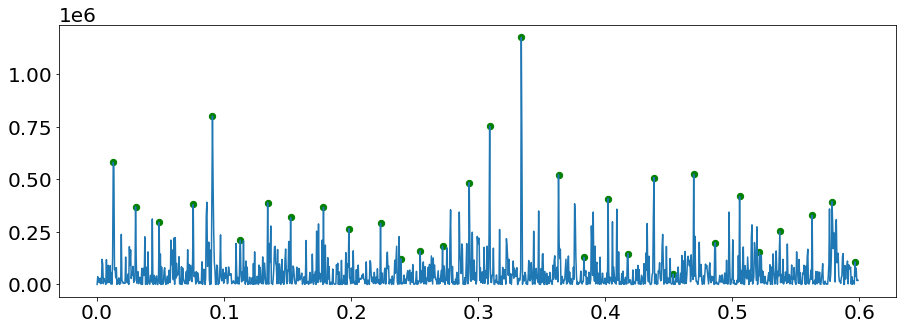

In [43]:
# Decomposition in batches of .6 s
fs = 2048
batch_size = .6
end_time = flatten_signal(gl_10).shape[1] / fs

time = 0.0

raw = crop_data(gl_10, start = time, end = time+batch_size)

# Source extraction
s, x_ext = source_extraction(raw, B_rt_gl10)
print(f"s.shape={s.shape}")

# Peak extraction
s2, peak_indices = peak_extraction(s)
print(f"s2.shape={s2.shape}")
print(f"peak_indices.shape={peak_indices.shape}")

# Spike classification
MUPulses, centroid_dists, signal, noise = spike_classification(s2, 
                                                               peak_indices, 
                                                               use_kmeans=False, 
                                                               thd_sil=.825, 
                                                               thd_dist_ratio=.2, 
                                                               classify=False, 
                                                               sil_dist=True)


print(f"centroid_dist: {centroid_dists}")
print("number of signal peaks:", signal["n_signal"])
print("number of noise peaks:", noise["n_noise"])
print(noise["noise_clusters"].size)

plt.rcParams['figure.figsize'] = [15, 5]
t_axis = np.arange(0, s2.shape[1], dtype="float") / float(fs)
plt.plot(t_axis, s2[0])
plt.scatter(MUPulses[0]/fs, s2[0][MUPulses[0]], c='g', s=40)
plt.show()

# plot_peaks(s2, noise, signal, centroid_dists)



s.shape=(16, 1228)
s2.shape=(16, 1228)
peak_indices.shape=(16,)


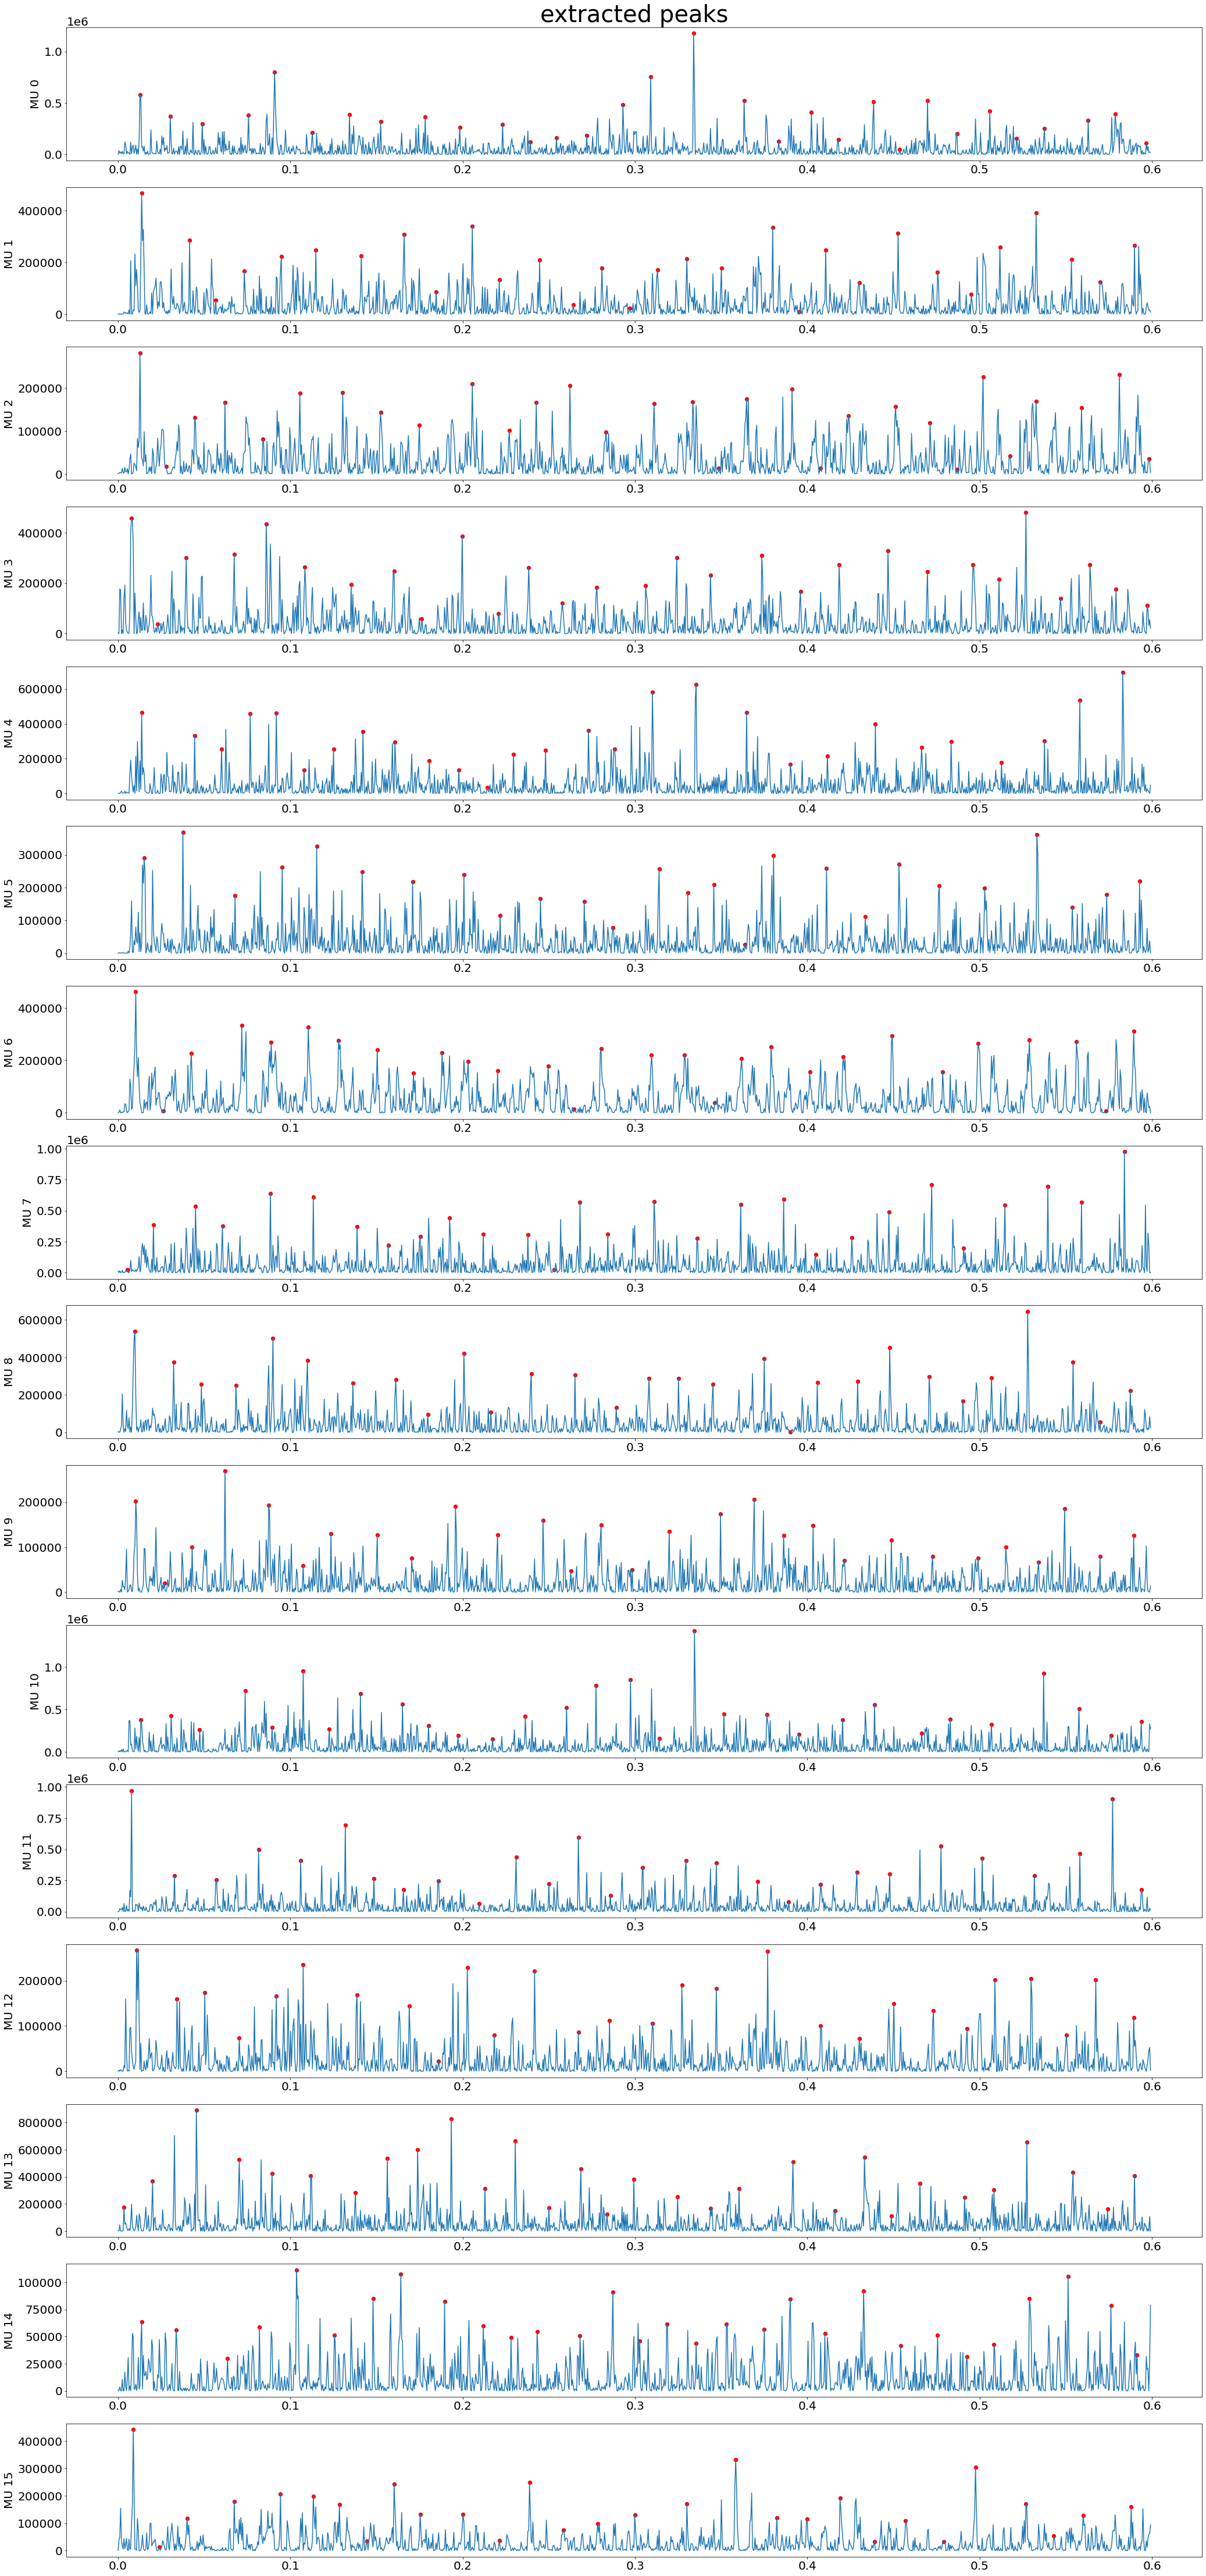

MUPulses.shape=(16,)


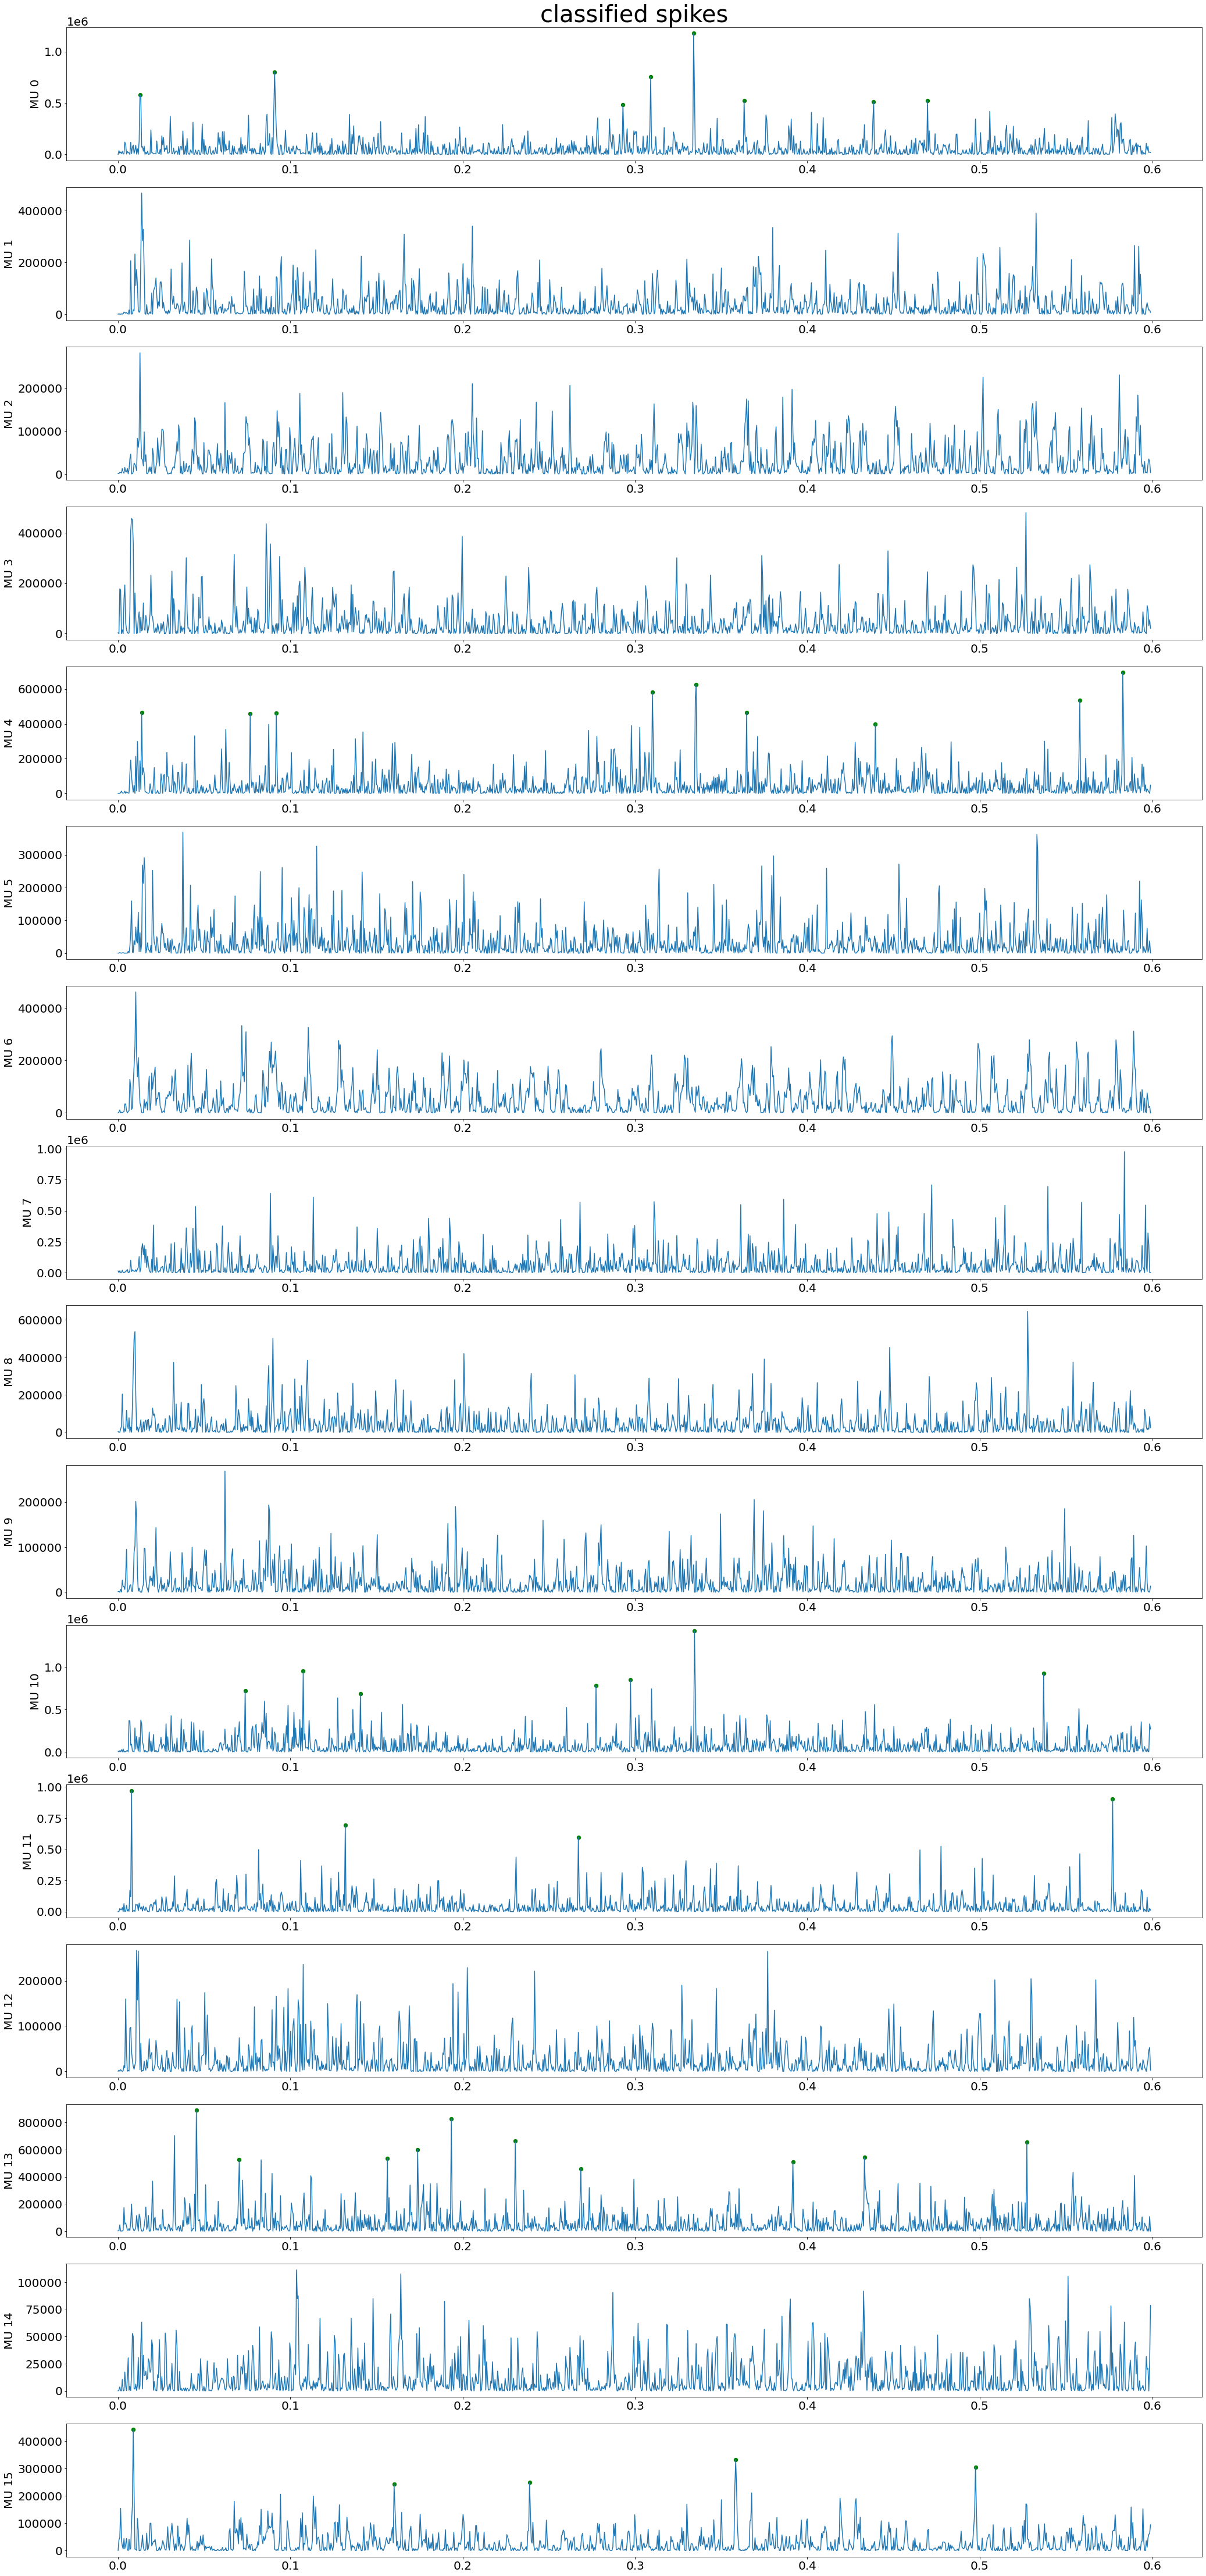

In [42]:
# Separation matrix from decomposition
B_gl10 = decomp_gl_10["B"]

# Separation matrix for realtime decomposition
B_rt_gl10 = sep_realtime(gl_10, B_gl10)

# Decomposition in batches of .6 s
fs = 2048
batch_size = .6
end_time = flatten_signal(gl_10).shape[1] / fs

time = 0.0

raw = crop_data(gl_10, start = time, end = time+batch_size)

# Source extraction
s, x_ext = source_extraction(raw, B_rt_gl10)
print(f"s.shape={s.shape}")

# Peak extraction
s2, peak_indices = peak_extraction(s)
print(f"s2.shape={s2.shape}")
print(f"peak_indices.shape={peak_indices.shape}")

# Plotting extracted peaks
plot_extracted_peaks(s2, peak_indices)


# Spike classification
if time == 0:
    MUPulses, _, _, _ = spike_classification(s2, peak_indices, sil_dist = True)
    time += batch_size
else:
    tmp = []
    MUPulses_curr, _, _, _ = spike_classification(s2, peak_indices, sil_dist = True)
    MUPulses_curr = MUPulses_curr + int(time*fs)
    
    for j in range(MUPulses.shape[0]):
        tmp.append(np.append(MUPulses[j], MUPulses_curr[j]))
    tmp = np.array(tmp, dtype="object")
    MUPulses_curr = tmp
    MUPulses = MUPulses_curr
    time += batch_size

# MUPulses = np.array(peak_indices, dtype="object")
print(f"MUPulses.shape={MUPulses.shape}")

# Plotting classified spikes
plot_classified_spikes(s2, MUPulses)

decomp_gl10_rt = {"MUPulses": np.array(MUPulses, dtype="object")}


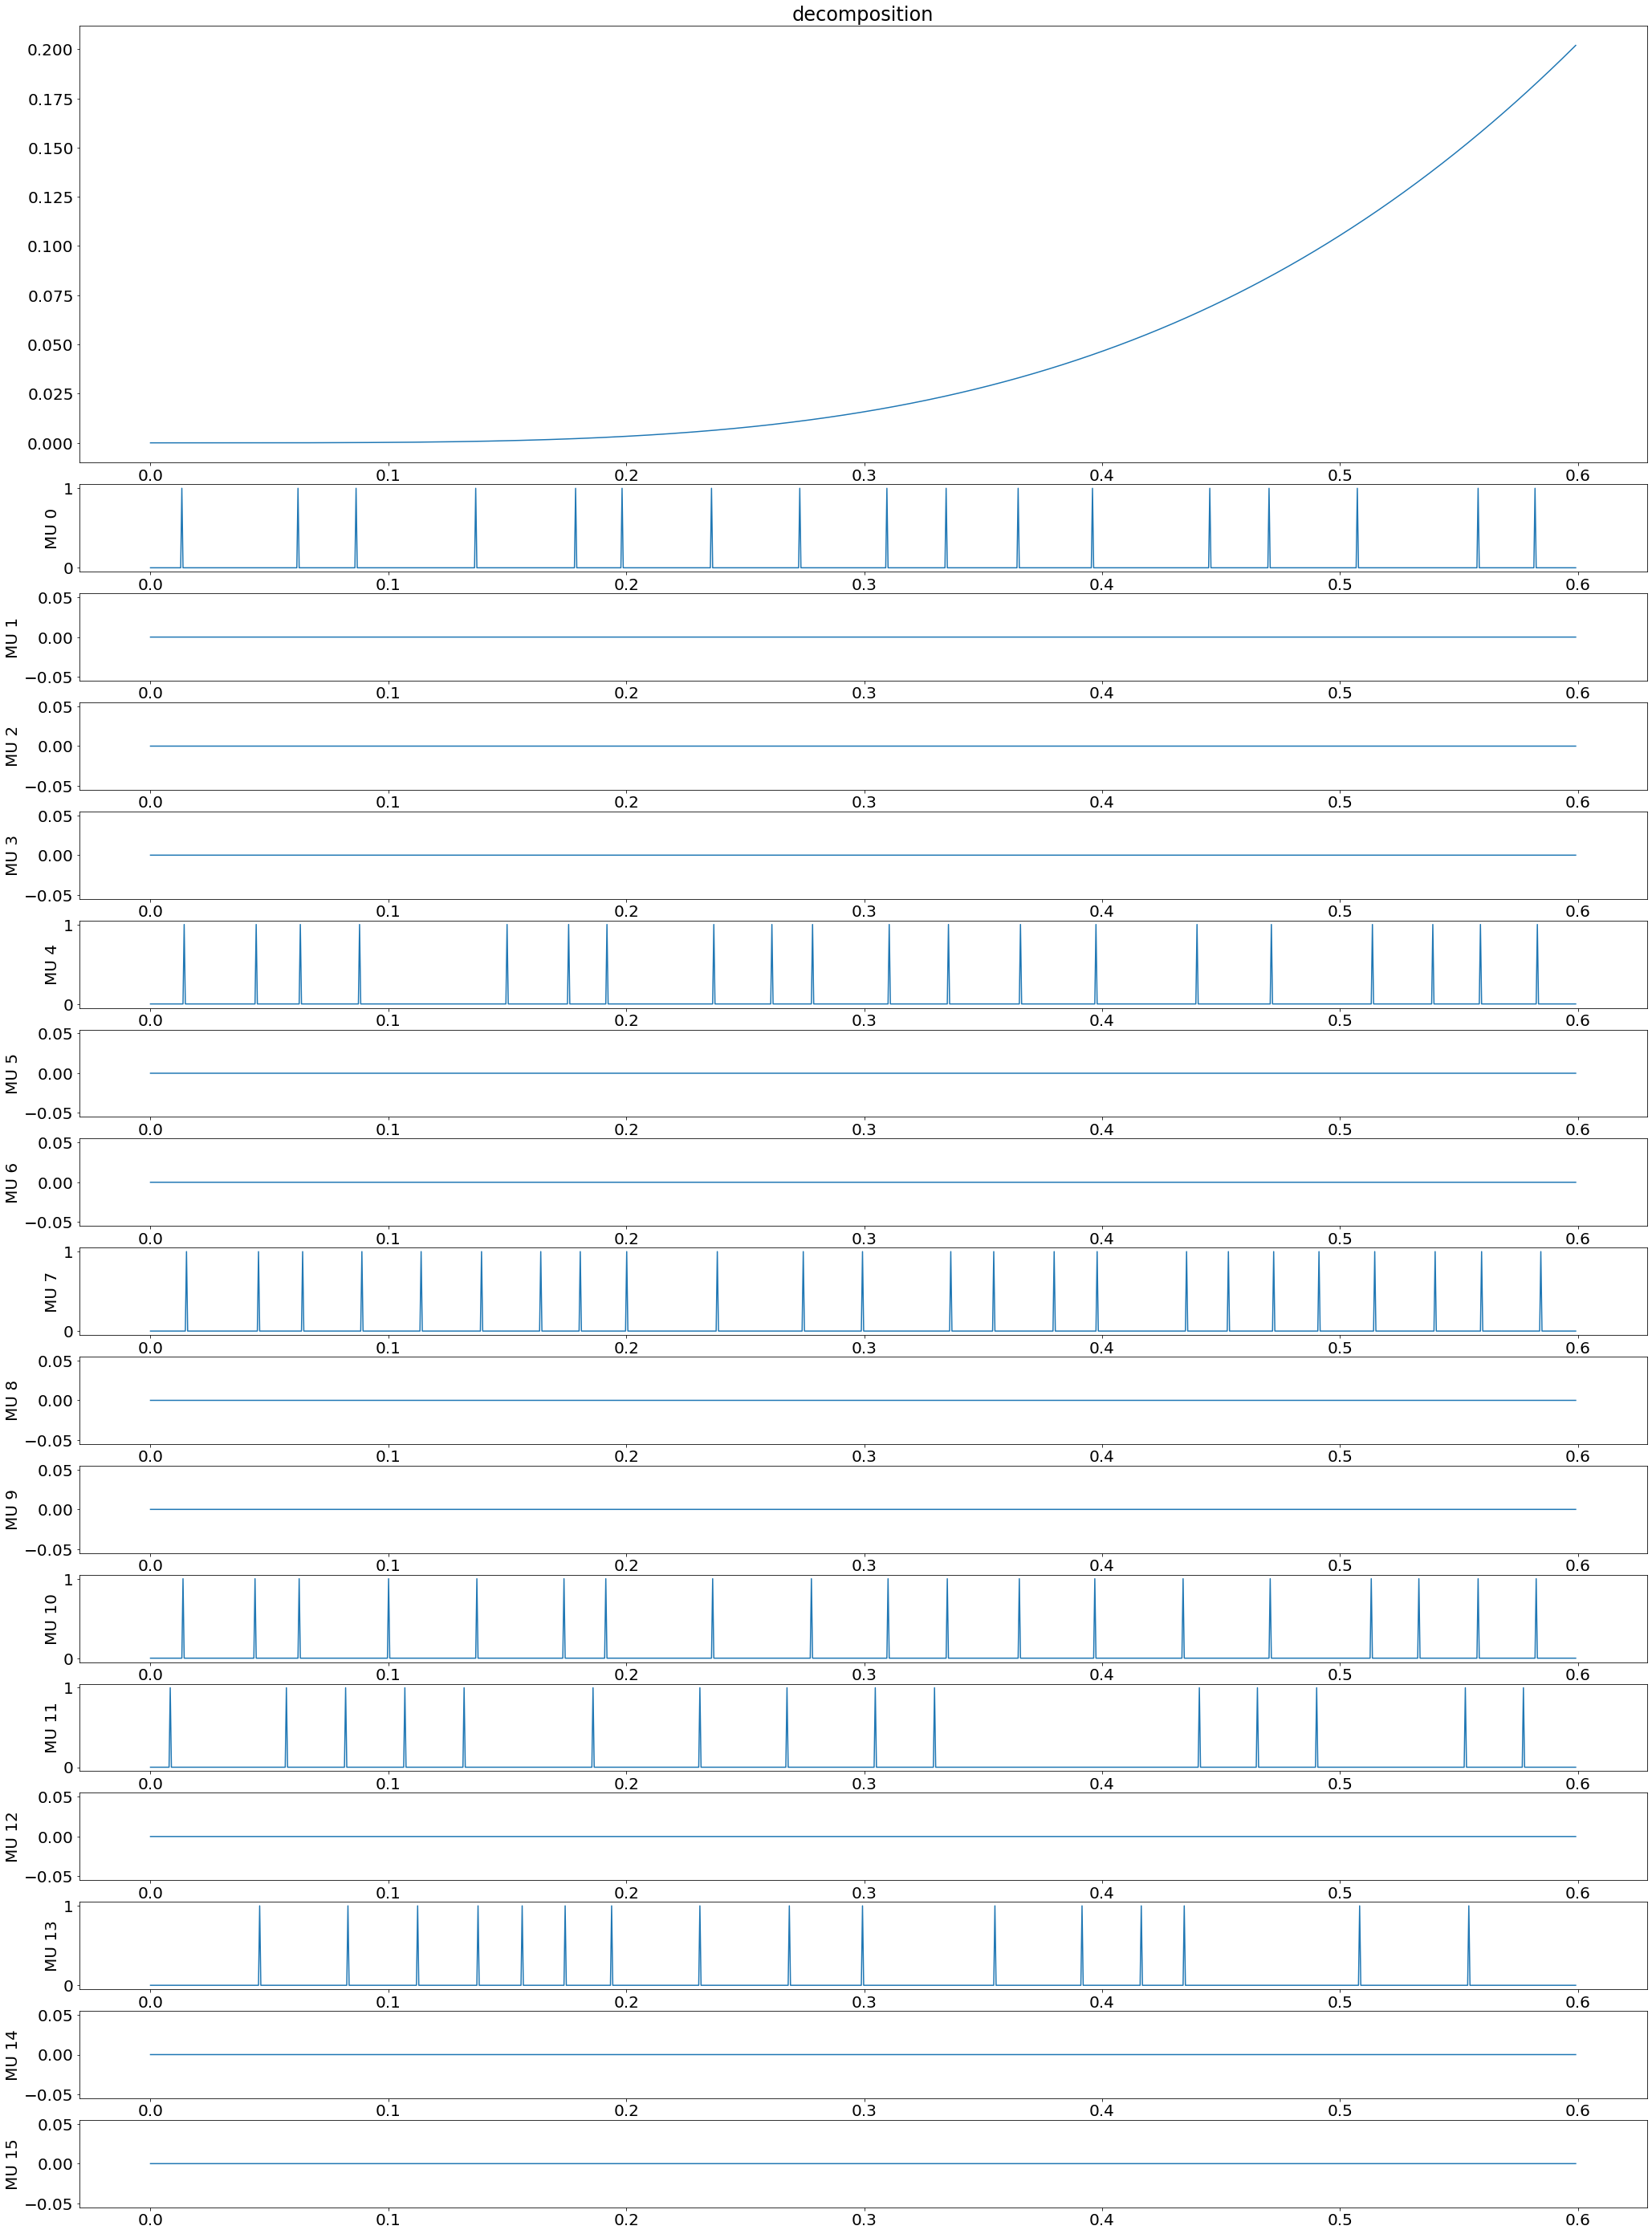

In [276]:
visualize_pt_window(decomp_gl_10["MUPulses"], gl_10, start=0.0, end=0.6, title="decomposition")

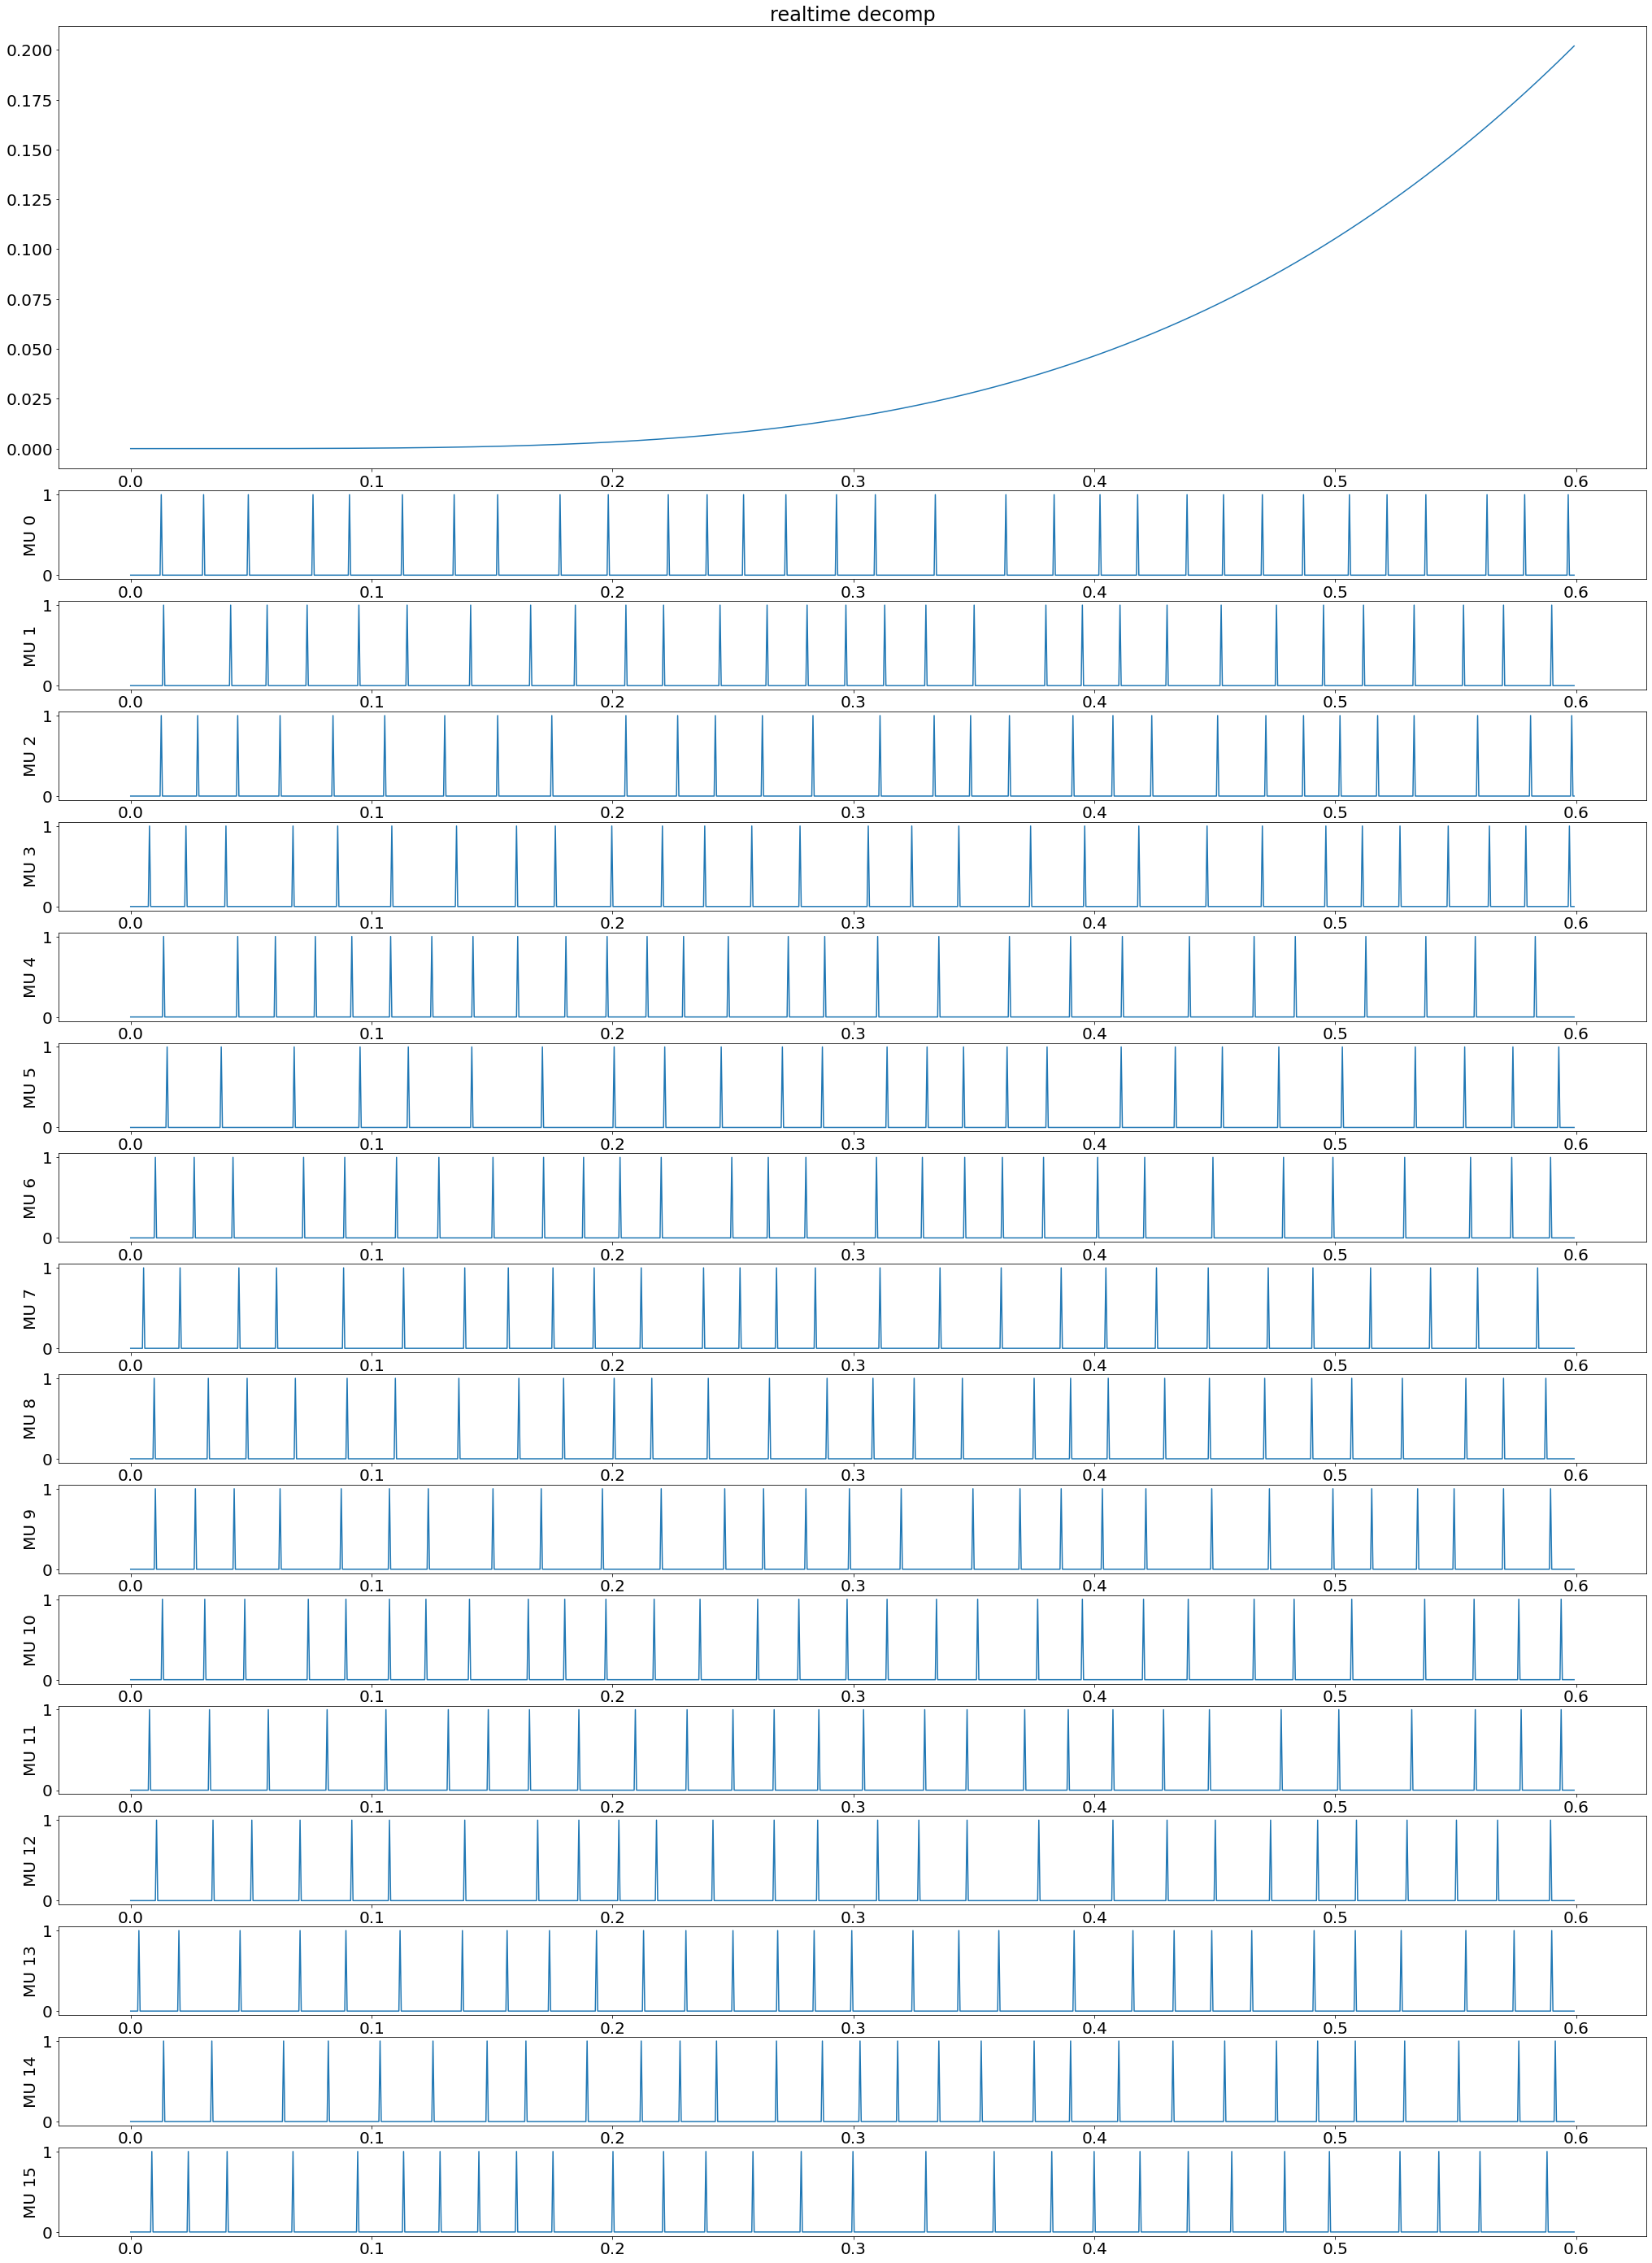

In [44]:
visualize_pt(MUPulses, crop_data(gl_10, start=0.0, end=0.6), title="realtime decomp")

### Decomposition of `gl_10` in batches

In [35]:
# Separation matrix from decomposition
B_gl10 = decomp_gl_10["B"]

# Separation matrix for realtime decomposition
B_rt_gl10 = sep_realtime(gl_10, B_gl10)

# Decomposition in batches of .6 s
fs = 2048
batch_size = .6
end_time = flatten_signal(gl_10).shape[1] / fs

time = 0.0
while True:
    raw = crop_data(gl_10, start = time, end = time+batch_size)

    # Source extraction
    s, x_ext = source_extraction(raw, B_rt_gl10)

    # Peak extraction
    s2, peak_indices = peak_extraction(s)
    
    # Spike classification
    if time == 0.0:
        MUPulses, _, _, _ = spike_classification(s2, peak_indices, sil_dist = True)
        time += batch_size
    else:
        tmp = []
        MUPulses_curr, _, _, _ = spike_classification(s2, peak_indices, sil_dist = True)
        MUPulses_curr = MUPulses_curr + int(time*fs)

        for j in range(MUPulses.shape[0]):
            tmp.append(np.append(MUPulses[j], MUPulses_curr[j]))
        tmp = np.array(tmp, dtype="object")
        MUPulses_curr = tmp
        MUPulses = MUPulses_curr    
        time += batch_size

    if time >= end_time:
        break

decomp_gl10_rt = {"MUPulses": MUPulses}

#### Comparison

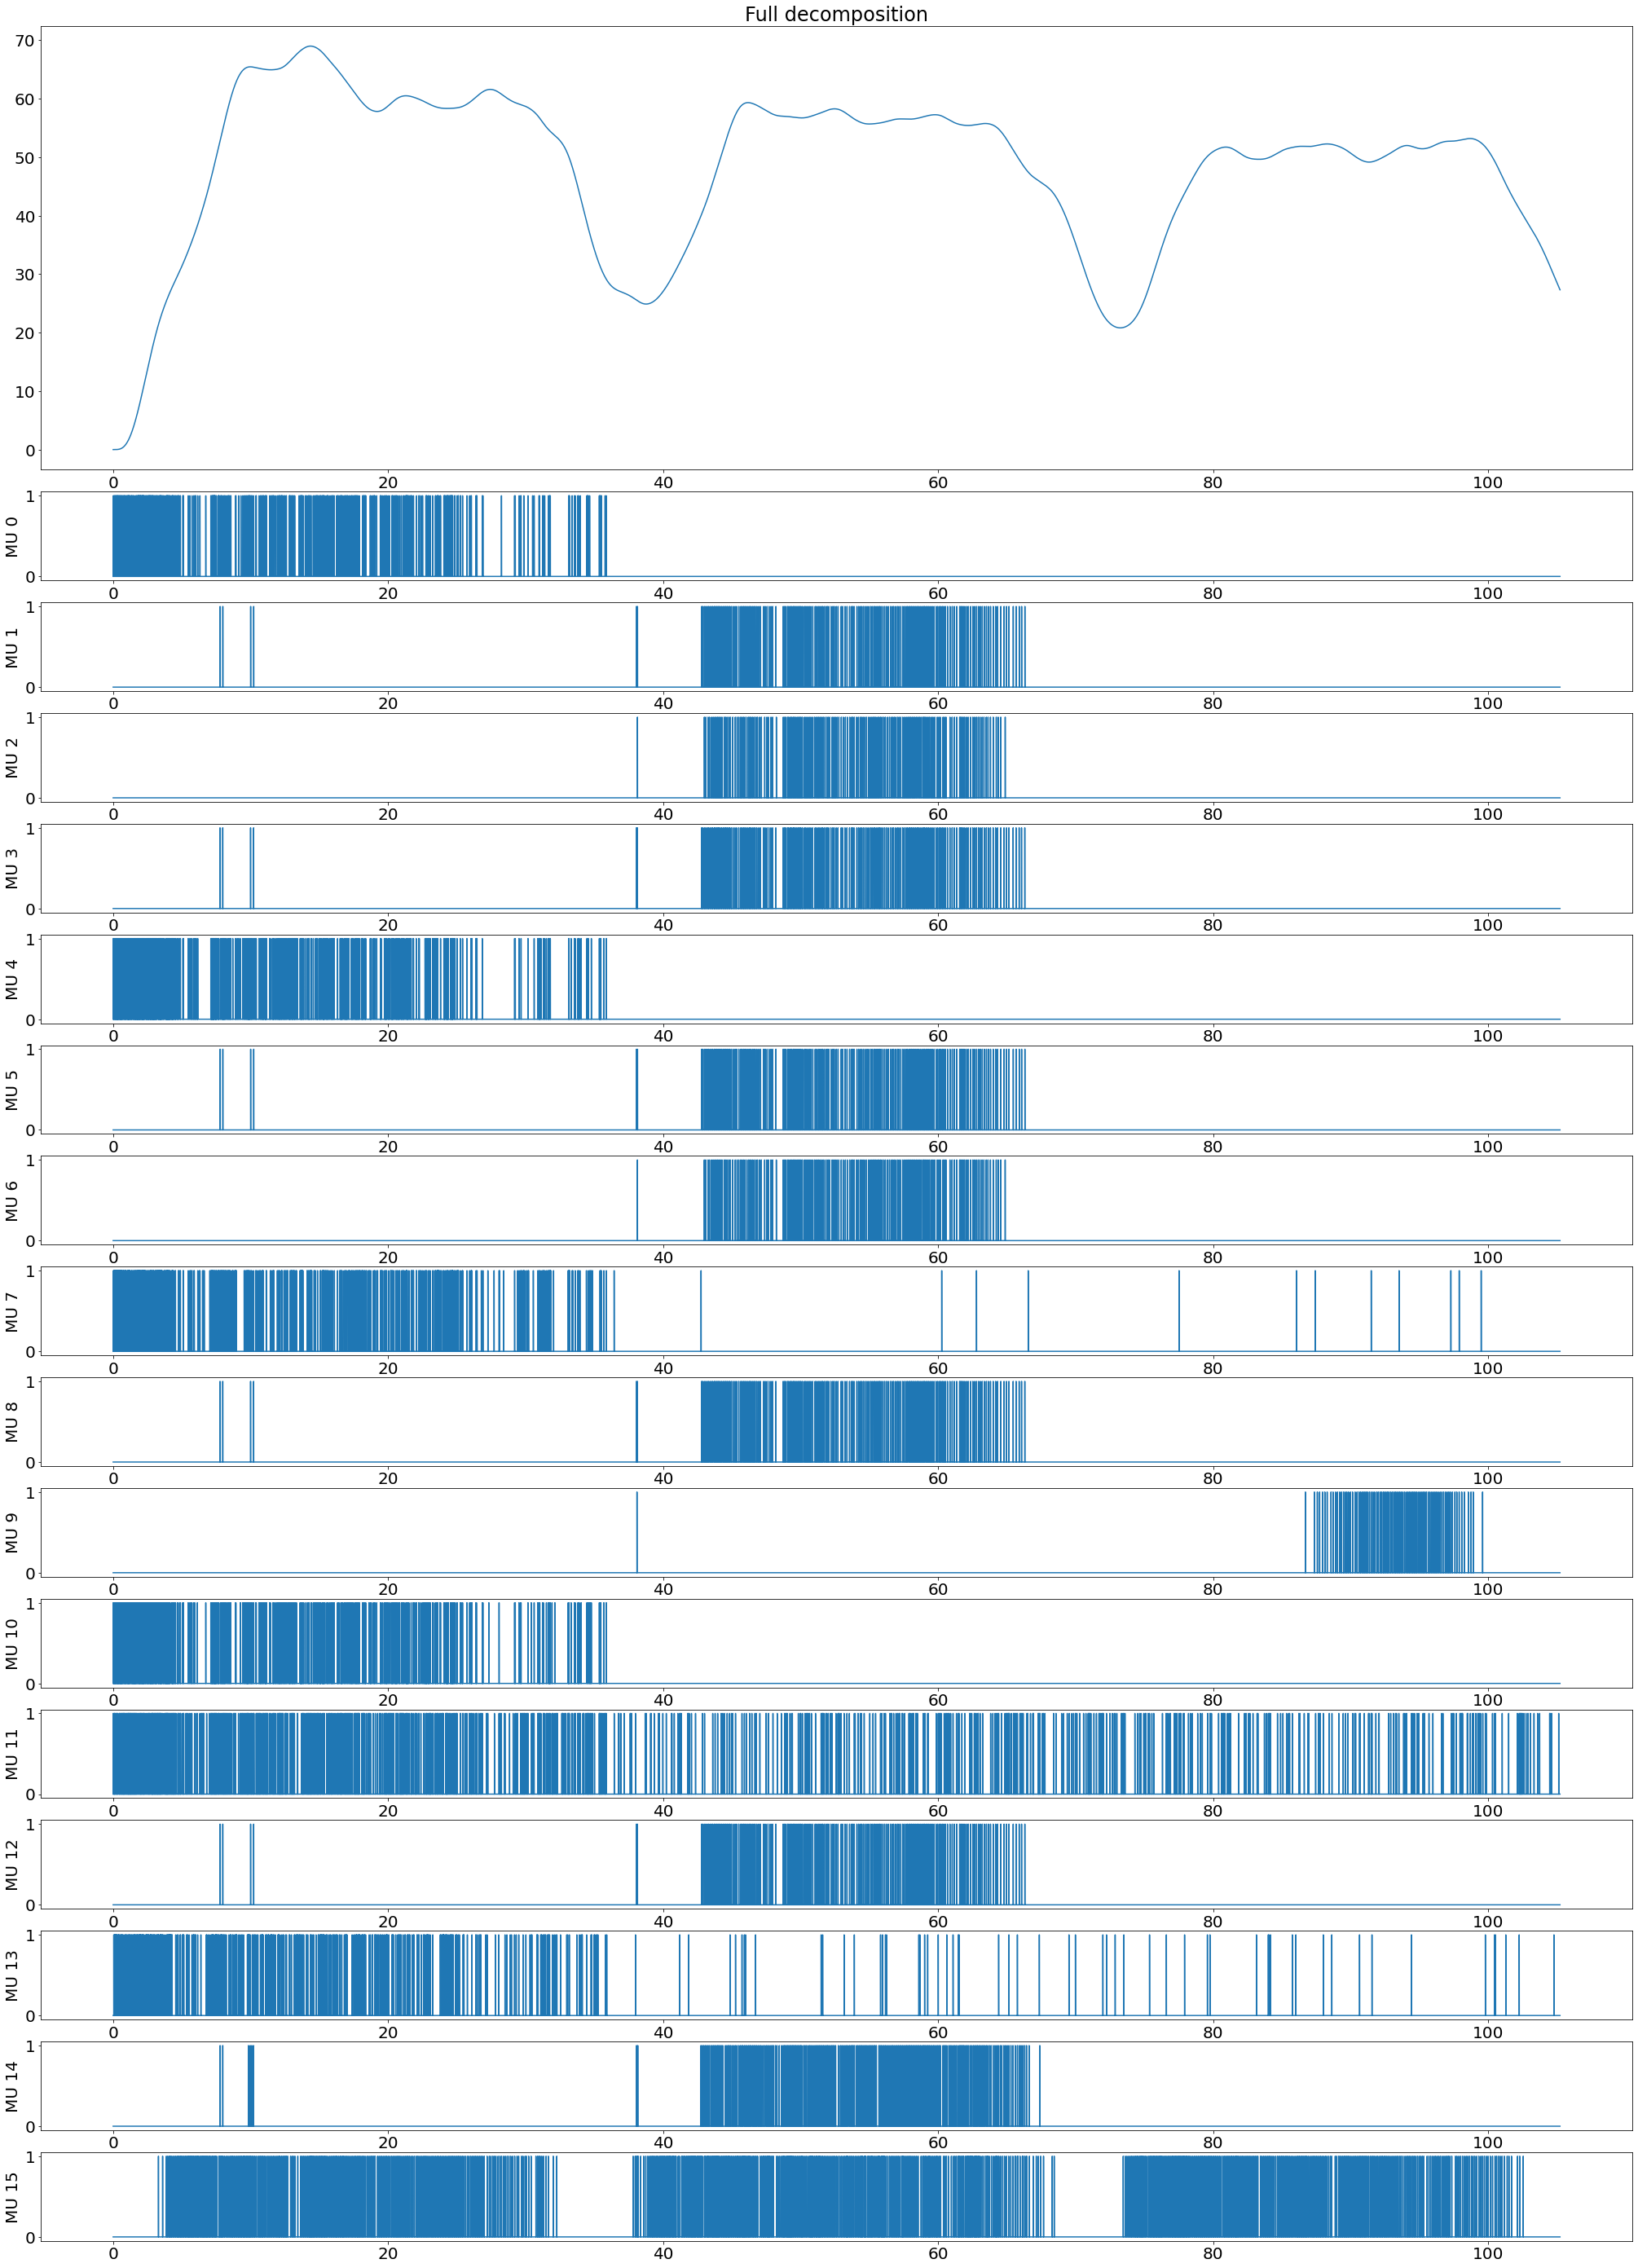

In [51]:
visualize_pt(decomp_gl_10["MUPulses"], gl_10, title="Full decomposition")

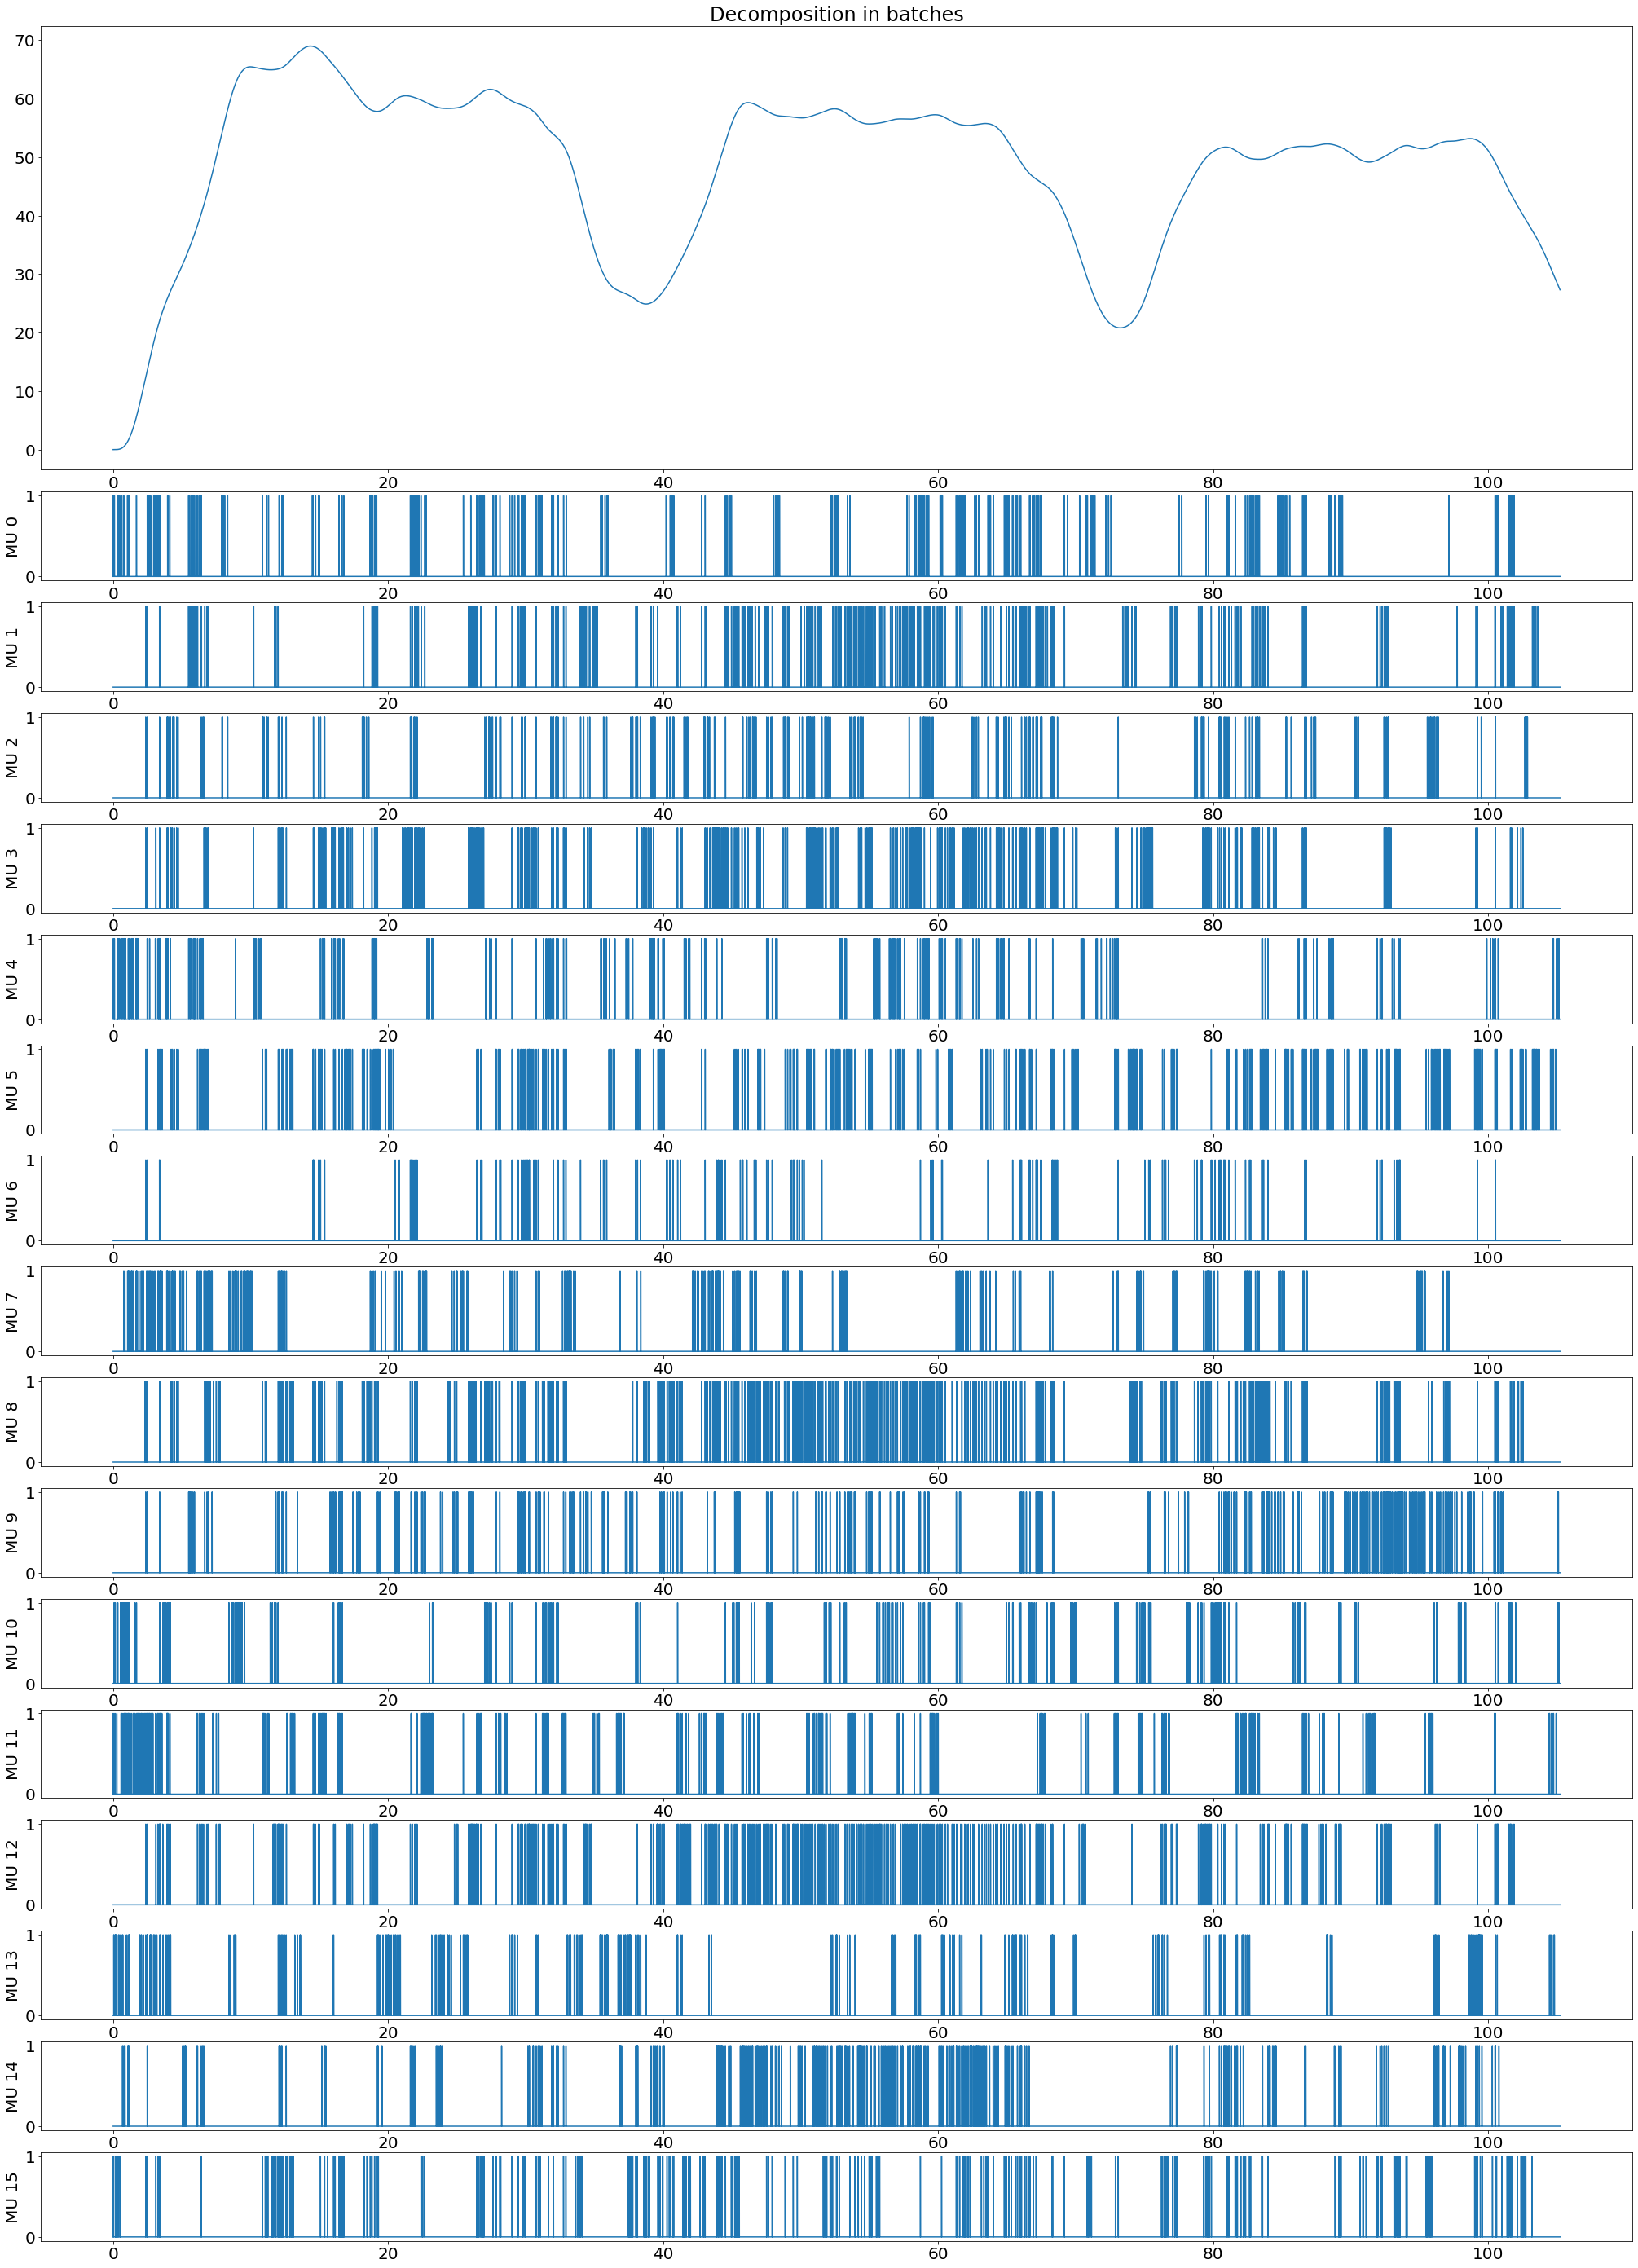

In [36]:
visualize_pt(decomp_gl10_rt["MUPulses"], gl_10, title="Decomposition in batches")